* Link to wfdb library https://github.com/MIT-LCP/wfdb-python
* Tutorial notebook https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb 

In [ ]:
!pip install wfdb

In [ ]:
!pip install PyWavelets

In [ ]:
!pip install tqdm 

In [2]:
from torch import nn
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pywt
import numpy as np
# to read .hea files
from wfdb import rdsamp
from IPython.display import display
import matplotlib.pyplot as plt
import glob, os
from torch.utils.data import TensorDataset, DataLoader, Dataset
from math import floor
import pickle
from tqdm import tqdm
import pandas as pd
import time

In [3]:
# Parameters of sampling
input_length = 101
delta0 = 50
delta1 = 25
freq = 360
batch_size = 10

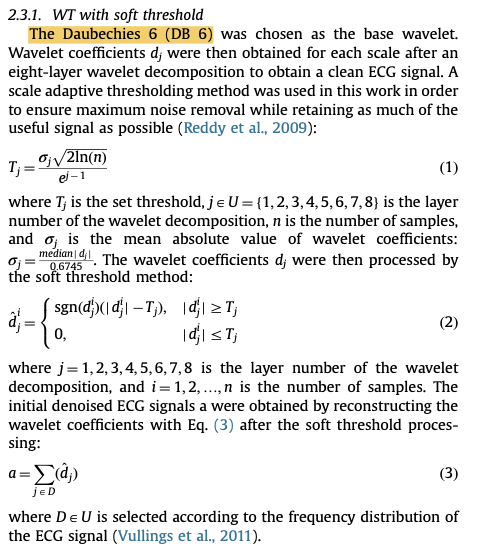

In [4]:
def calculateT(sigma, j, n):
  return sigma*np.sqrt(2*np.log(n))/np.exp(j-1)


def calculateSigma(sequence: np.array):
#   sequence = np.asarray(sequence)
  return np.median(sequence)/0.6745


def calculateDhat(T, sequence):
  return pywt.threshold(sequence, T, 'soft')


def reconstructA(sequence):
  return np.sum(sequence) # todo: which axis?

#here sequence is (m,n) array of ECG samples
def prepare(sequence, n):
  coeff = []
  dec = pywt.wavedecn(sequence, 'db6', level=8, axes=0)
  
  for i in range(1,9):
    sigmas = np.apply_along_axis(calculateSigma, 0, dec[i]['d'])
    Ts = np.apply_along_axis(calculateT, 0, sigmas, j=i, n=n)
    new_coeff = {'d': np.apply_along_axis(calculateDhat, 0, Ts, dec[i]['d'] )}
    coeff.append(new_coeff)
  coeff.insert(0, dec[0])
  reconstruction = pywt.waverecn(coeff, 'db6', axes=0)
  
  return reconstruction

# here sequence is (n, m, k) array of ECG samples,
# where n is batch size, m is length, k is number of channels
def prepare2(sequence, n):
  """
  Wavelet preprocessing of noisy data
  """
  coeff = []
  dec = pywt.wavedecn(sequence, 'db6', level=8, axes=1)
  for i in range(1,9):
    sigmas = np.apply_along_axis(calculateSigma, 1, dec[i]['d'])
    Ts = np.apply_along_axis(calculateT, 1, sigmas, j=i, n=n)
    for j in range(len(Ts)):
        dec[i]['d'][j] = calculateDhat(dec[i]['d'][j], Ts[j])
  reconstruction = pywt.waverecn(dec, 'db6', axes=1)
  
  return reconstruction

In [5]:

# np.around is faster than round

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], 
            out_features=int(kwargs["input_shape"]/2)
        )
        self.encoder_output_layer = nn.Linear(
            in_features=int(kwargs["input_shape"]/2), 
            out_features=int(kwargs["input_shape"]/2)
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=int(kwargs["input_shape"]/2), 
            out_features=int(kwargs["input_shape"]/2)
        )
        self.decoder_output_layer = nn.Linear(
            in_features=int(kwargs["input_shape"]/2), 
            out_features=kwargs["input_shape"] 
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.sigmoid(activation)
        code = self.encoder_output_layer(activation)
        code = self.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = self.sigmoid(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = self.sigmoid(activation)
        return reconstructed

**Signal to noise for noise stress test database**  

* frequency if 360 Hz

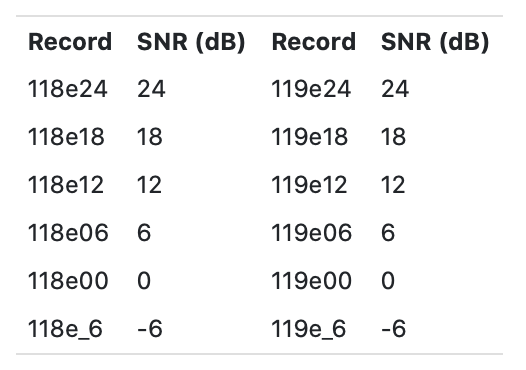

**For MIH Arythmia dataset**  
The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.  


* original way of adding noise to clean recordings https://physionet.org/physiotools/wag/nst-1.htm.   

**They have added only em noise in the original database and only one type of noise in the article** 

* The three noise records were assembled from the recordings by selecting intervals that contained predominantly baseline wander (in record 'bw'), muscle (EMG) artifact (in record 'ma'), and electrode motion artifact (in record 'em'). Electrode motion artifact is generally considered the most troublesome, since it can mimic the appearance of ectopic beats and cannot be removed easily by simple filters, as can noise of other types.  

**Important info from the article about the training process**  

* Calculating the mean of the overlapping portions allows for the normalization of denoised ECG signal data and fusion after excluding negligent errors. In this study, this procedure was repeated ten times. Each time, the training data contained 30 000 samples and the testing data contained 2000 samples.

## Noisy samples generation

* The names will be like numberOfCleanRecord_noiseName_SNR. For example, 209_em_1-5.csv or 209_em_1-5_bw-1-0.csv , '-' is used instead of dot
* Noisy recordings will need about 30Gb
* Dataset creation needs more memory than default 1Gb, 2 is enough. The guide how to change jupiter settings is here https://towardsdatascience.com/leveraging-the-power-of-jupyter-notebooks-26b4b8d7c622

In [6]:
# TODO define records here
path = 'mitdb'
em_noise = rdsamp('nstdb/em')[0]
ma_noise = rdsamp('nstdb/ma')[0]
bw_noise = rdsamp('nstdb/bw')[0]

basic = [0, 1, 1.25, 1.5, 2, 3, 4, 5]

In [7]:
# em, ma, bw are 1 if this noise is needed and 0 if not
def add_noise(record, ratio_em=0, ratio_ma=0, ratio_bw=0, em=1, ma=1, bw=1):
  return record+ratio_em*em*em_noise+ratio_ma*ma*ma_noise+ratio_bw*bw*bw_noise


#without extention
def get_records_names(path):
    records = []
    os.chdir(path)
    for file in glob.glob("*.hea"):
        records.append(file[0:3])
    os.chdir('..') 
    return records


def gen_single_noise(snrs, save=False,em=True, ma=True, bw=True, return_needed=False, path_to_save='noisy/single/'):
    names = get_records_names(path)
    mas = []
    bws = []
    ems = []
    for n in names:
        name = rdsamp(f'{path}/{n}')[0]
        for s in snrs:
            if em:
                with_em = add_noise(name, ratio_em=s, ratio_ma=0, ratio_bw=0, em=1, ma=0, bw=0)
                if save:
                    np.savetxt(f'{path_to_save}{n}_em_{s}.csv', (with_em), delimiter=',')
            if bw:
                with_bw = add_noise(name, ratio_em=0, ratio_ma=0, ratio_bw=s, em=0, ma=0, bw=1)
                if save:
                    np.savetxt(f'{path_to_save}{n}_bw_{s}.csv', (with_bw), delimiter=',')
            if ma:
                with_ma = add_noise(name, ratio_em=0, ratio_ma=s, ratio_bw=0, em=0, ma=1, bw=0)
                if save:
                    np.savetxt(f'{path_to_save}{n}_ma_{s}.csv', (with_ma), delimiter=',')
                    
            if return_needed:
                ems.append(with_em)
                bws.append(with_bw)
                mas.append(with_ma)
                
    return ems, mas, bws

## Generate single-noised data (next cell)

Clear data is stored in `mitdb/` folder, while noised is in `noisy/single/`  
A match between x & y is filename (file index) : `238.csv` & `238.hea`  

In [8]:
# commented not to play without intention
gen_single_noise(basic, save=True)

KeyboardInterrupt: 

In [60]:
def get_all_paths(path='noisy/single'):
    """
    Function returns all .csv filenames within `path` directory
    """
    return list(glob.glob(f'{path}/*.csv'))

# p in [0;100] 10 is 10%
def separate_for_test(p: int):
    """
    Function retuns a list of filenames for train and test dataset
    :param p: percentage of test files
    """
#     for_test  = []
#     for_train = []
    paths = get_all_paths()
    np.random.shuffle(paths)
    
    l = int(len(paths) * p / 100.)
    
    test_fnames = paths[:l]
    train_fnames = paths[l:]
    
    return train_fnames, test_fnames
#     l = len(paths)
#     print(l)
#     print(p)
#     each = int(100/p)
#     indexes = list(range(0, l, each))
#     indexes.reverse()
#     for i in indexes:
#         for_test.append(paths.pop(i))
#     for_train = paths
#     return for_train, for_test


def process_one_file(filename: str, size: int) -> list: # List[np.array]
    """
    Function returns content of one file, it contains two channels
    In case of wrong size, it shrinks to the required one
    
    :return : non-shuffled collection of sequence (length=size) with two channels [total // size, size, 2] 
    """
    x = pd.read_csv(train_fnames[0], header=None).values
    rows = len(x) % size
    if rows != 0:
        x = x[:-rows]
    return x.reshape(len(x) // size, size, 2)

        
def process_pair(fname: str, size: int):
    x = process_one_file(fname, size)
    y = process_one_file(f'{fname[0:16]}_em_0.csv', size)
    return x, y


def create_dataset(fnames: list, size: int):
    '''
    Function creates a torch Dataset from a list of file names
    '''
    xs = []
    ys = []
    for fname in fnames:
        x, y = process_pair(fname, size)
        xs.extend(x)
        ys.extend(y)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return TensorDataset(xs, ys)  


# https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader 
def create_datasets(p: int, size:int=100):
    '''
    Function creates training and test datasets with specified split size (p)
    Also shrinks files according to size
    '''
    for_train, for_test = separate_for_test(p)
    train_dataset = create_dataset(for_train, size)
    test_dataset = create_dataset(for_test, size)
    return train_dataset, test_dataset, for_train, for_test


def save_datasets_to_disk(filename, dataset):
    with open(f'{filename}.pkl', 'wb') as output:
        pickle.dump(dataset, output, protocol=4) 
    
    
def load_dataset_from_hard(filename):
    load_train_dataset = TensorDataset()
    with open(f'{filename}.pkl', 'rb') as input_file:
        load_train_dataset = pickle.load(input_file) 


## Test correctness

Read all files and check shapes

In [61]:
def load_n_preprocess(fname, size):
    x, y = process_pair(fname, size)  # [N, 100, 2]
    
    x = prepare2(x, len(x))
    
    x_min, x_max = x.min(1)[:, None], x.max(1)[:, None] # add dimension [N, 2] -> [N, 1, 2]
    y_min, y_max = y.min(1)[:, None], y.max(1)[:, None] # add dimension [N, 2] -> [N, 1, 2]
    x = (x - x_min) / (x_max - x_min)
    y = (y - y_min) / (y_max - y_min)
    
    # if there is nan on second channel, drop those rows
    mask = ((y_min[:, :, :] == y_max[:, :, :]) | (x_min[:, :, :] == x_max[:, :, :])).squeeze(1)
    mask =  (mask[:, 0] | mask[:, 1])
    x = x[~mask]
    y = y[~mask]

    return x, y

In [62]:
t0 = time.time()
# File load
x, y = process_pair(train_fnames[0], 100)  # [N, 100, 2]
t1 = time.time()

# Wavelet denoising
x = prepare2(x, len(x))
t2 = time.time() 

# Min-max normalization
x_min, x_max = x.min(1)[:, None], x.max(1)[:, None] # add dimension [N, 2] -> [N, 1, 2]
y_min, y_max = y.min(1)[:, None], y.max(1)[:, None] # add dimension [N, 2] -> [N, 1, 2]

x = (x - x_min) / (x_max - x_min)
y = (y - y_min) / (y_max - y_min)


# mask = (y_min[:, :, :] == y_max[:, :, :]).squeeze(1)
mask = ((y_min[:, :, :] == y_max[:, :, :]) | (x_min[:, :, :] == x_max[:, :, :])).squeeze(1)
    
mask =  (mask[:, 0] | mask[:, 1])
x = x[~mask]
y = y[~mask]

t3 = time.time()
# Tensoring
x = torch.tensor(x, dtype=torch.float32, device='cpu').permute(0, 2, 1)
y = torch.tensor(y, dtype=torch.float32, device='cpu').permute(0, 2, 1)
t4 = time.time()

fload = t1 - t0
preparing = t2 - t1
normalization = t3 - t2
tensoring = t4 - t3

print(f'File loading: {fload:.2f} sec.\n'
      + f'Wavelet prepare: {preparing:.2f} sec.\n'
      + f'Min-Max normalization: {normalization:.2f} sec.\n'
      + f'tensoring: {tensoring:.2f} sec.')

File loading: 0.41 sec.
Wavelet prepare: 6.13 sec.
Min-Max normalization: 0.05 sec.
tensoring: 0.01 sec.


## Dump preprocessed data

Here we dump preprocessed data into csv files:  

1) Added noise  
2) Adjusted signals by min-max scaling  
3) Apply wavelet denoising  
4) Store on disk  

In [63]:
import os
import glob
import math

train_samples_path = 'samples-train'
test_samples_path = 'samples-test'


if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)

if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)

In [64]:
size = 100
for fname in tqdm(train_fnames):
    x, y = load_n_preprocess(fname, 100)
    if np.isnan(x).any():
        print(f'{fname} X has nan')
        continue
        
    if np.isnan(y).any():
        print(f'{fname} Y has nan')
        continue
        
    fname_ = fname.rsplit('/')[-1][:-4] # get rid of `dir1`/`dir2`/... and `.csv`
    np.save(f'{train_samples_path}/{fname_}_x.npy', x)
    np.save(f'{train_samples_path}/{fname_}_y.npy', y)    
    
for fname in tqdm(test_fnames): # todo: there is no check for nans
    x, y = load_n_preprocess(fname, 100)
    if np.isnan(x).any():
        print(f'{fname} X has nan')
        continue
        
    if np.isnan(y).any():
        print(f'{fname} Y has nan')
        continue
        
    fname_ = fname.rsplit('/')[-1][:-4] 
    np.save(f'{test_samples_path}/{fname_}_x.npy', x)
    np.save(f'{test_samples_path}/{fname_}_y.npy', y)    

100%|██████████| 115/115 [12:50<00:00,  6.70s/it]


In [ ]:
# X nans in two files: noisy/single/202_ma_0.csv, noisy/single/202_bw_0.csv

# Model training

## Define dataloader

Dataloader takes multiple files at a time, concatenates content and shuffles it.  
Concatenation with other files is required due to different `noise` patterns, which are important to be learnt.  

In [65]:
def criterion(x, y):   
    t = -(y * torch.log(x) + (1 - y) * torch.log(1 - x)) / x.shape[0]
    t[t == float("Inf")] = 0
    t[t == -float("Inf")] = 0
    t[torch.isnan(t)] = 0
    return t.sum() / len(x)

class MyFileDataset(Dataset):
    def __init__(self, folder: str, files_to_mix: int):
        self.folder = folder
        xs_fnames = sorted(glob.glob(f'{folder}/*_x.npy'))
        ys_fnames = sorted(glob.glob(f'{folder}/*_y.npy'))
        self.pairs = list(zip(xs_fnames, ys_fnames))
        self.quantity = files_to_mix
    
    def __len__(self) -> int:
        return len(self.pairs) // self.quantity # 4.2 -> 5
    
    def __getitem__(self, idx: int):
        pairs = self.pairs[idx * self.quantity:(idx + 1) * self.quantity]
        return pairs
    
class MyMixedDataset(Dataset):
    def __init__(self, files: list, device): # list of (str, str) (fnames for x and y)
        self.device = device
        x_fnames, y_fnames = zip(*files)
        xs = [np.load(fname) for fname in x_fnames]
        ys = [np.load(fname) for fname in y_fnames]
        # reshaped into [N, 2, 100]
        self.xs = torch.cat([torch.tensor(x, dtype=torch.float, device=device).view(-1, 2, 100) for x in xs], dim=0)
        self.ys = torch.cat([torch.tensor(y, dtype=torch.float, device=device).view(-1, 2, 100) for y in ys], dim=0)
        
    def __len__(self) -> int:
        return self.xs.shape[0]
    
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

## Define model and datasets

In [66]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=100).to(device)
model.to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
# criterion = nn.CrossEntropyLoss()
device

device(type='cuda')

In [67]:
train_files_dataset = MyFileDataset(train_samples_path, 128)
test_files_dataset = MyFileDataset(test_samples_path, 1)
train_files_iter = iter(train_files_dataset)
test_files_iter = iter(test_files_dataset)

losses = []
minibatch_losses = []

epochs = 1

In [19]:
for i in range(len(train_files_dataset)):
    a = MyMixedDataset(train_files_dataset[i], device)
    xs = a.xs
    ys = a.ys
    checks = [torch.isnan(xs), torch.isinf(xs), torch.isnan(ys), torch.isinf(ys)]
    checks = [t.any().item() for t in checks]
    
    print(i, checks)

0 [False, False, False, False]
1 [False, False, False, False]
2 [False, False, True, False]
3 [False, False, False, False]
4 [False, False, False, False]
5 [False, False, False, False]
6 [False, False, False, False]
7 [False, False, True, False]


In [24]:
invalid_files = train_files_dataset[2] + train_files_dataset[7]

In [25]:
for _, fname in invalid_files:
    y_ = np.load(fname)
    if np.isnan(y_).any():
        print(fname)

samples-train/116_em_1.5_y.npy
samples-train/116_em_3_y.npy
samples-train/116_em_5_y.npy
samples-train/223_bw_1.25_y.npy
samples-train/223_bw_2_y.npy
samples-train/223_em_1.25_y.npy
samples-train/223_ma_5_y.npy


In [27]:
y_ = np.load('samples-train/116_em_1.5_y.npy')

In [71]:
# xs and ys are nan in first 128 files, possibly in others too
# 64-95 there is an xs mistake
# 64-79 there is an xs nan
# 80-95 there is an xs nan
epochs = 10

In [74]:
for epoch in range(epochs):
    
    loss = 0.0
    model.train()
    minibatch_counter = 0
    for i in tqdm(range(len(train_files_dataset))):
        dataset = MyMixedDataset(train_files_dataset[i], device)
        loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
        for x, y in tqdm(loader):
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(x)

            # compute training reconstruction loss
            train_loss = criterion(outputs, y)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            item = train_loss.item()
            loss += item
            minibatch_losses.append(item)
            minibatch_counter += 1
    
        # compute the epoch training loss
    loss = loss / minibatch_counter # loss per batch
    losses.append(item)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 1/10, loss = 0.928009



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 2/10, loss = 0.918677



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 3/10, loss = 0.913168



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 4/10, loss = 0.909303



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 5/10, loss = 0.906430



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 6/10, loss = 0.904221



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 7/10, loss = 0.902557



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 8/10, loss = 0.901217



  0%|          | 0/8 [00:00<?, ?it/s]

epoch : 9/10, loss = 0.900097



100%|██████████| 8/8 [03:04<00:00, 23.01s/it]

epoch : 10/10, loss = 0.899157


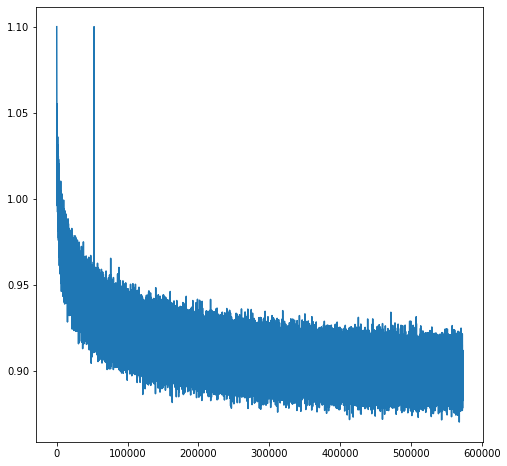

In [79]:
plt.figure(figsize=(8,8))
d = np.array(minibatch_losses)
d = d.clip(0, 1.1)
plt.plot(range(len(minibatch_losses)), d)

## Test Model

In [99]:
test_loss = 0
accuracy = 0

res = []
tests = []

# for i in tqdm(range(len(test_files_dataset))): 
for i in tqdm(range(3)): 
    dataset_test = MyMixedDataset(test_files_dataset[i], device)
    loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)
    for x,y in loader_test:
        output = model.forward(x)
        
        res.append(output)
        tests.append(y.data)
        
        test_loss += criterion(output, y).item()
        ps = torch.exp(output)
        equality = (y.data == ps)
        accuracy += equality.type(torch.FloatTensor).mean()

100%|██████████| 3/3 [00:00<00:00, 11.33it/s]


In [127]:
r1 = np.asarray(res[1].cpu().detach())
t1 = np.asarray(tests[1].cpu().detach())

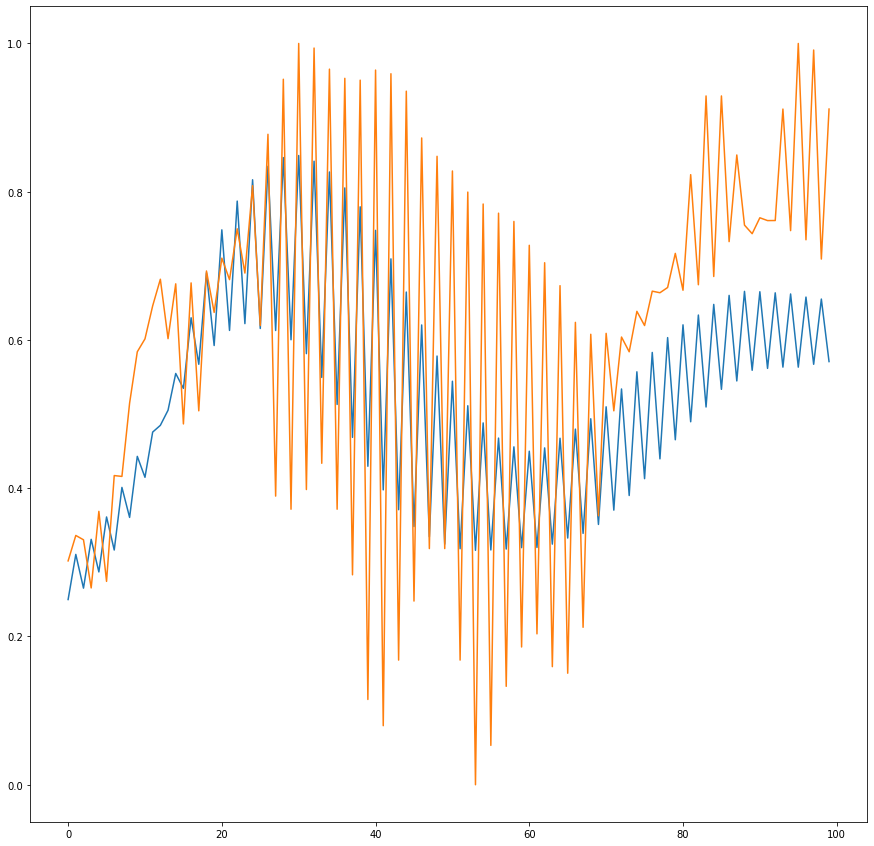

In [135]:
plt.figure(figsize=(15, 15))
plt.plot(r1[95, 1, :])
plt.plot(t1[95, 1, :])

In [126]:
test_loss/len(test_files_dataset)

1.2028735891632412

In [90]:
accuracy

tensor(0.)

In [ ]:
# first is non zero than 0s
losses_with_cross_entropy = losses

In [ ]:
loss = 0
it = iter(train_loader)
for _ in tqdm(range(200)):
    with torch.no_grad():
        x, y = next(it)
        x = (x - torch.min(x, 0)[0])/(torch.max(x, 0)[0]-torch.min(x,0)[0])
        y = (y - torch.min(y, 0)[0])/(torch.max(y, 0)[0]-torch.min(y, 0)[0])

        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        x = torch.tensor(prepare2(x, len(x)), dtype=torch.float).permute(0,2,1)
        x[torch.isnan(x)] = 0
        y = y.float().permute(0,2,1)

    batch_features = x.to(device)

    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()

    # compute reconstructions
    outputs = model(batch_features)

    # compute training reconstruction loss
    train_loss = criterion(y, outputs)

    # compute accumulated gradients
    train_loss.backward()

    # perform parameter update based on current gradients
    optimizer.step()

    # add the mini-batch training loss to epoch loss
    
    item = train_loss.item()
    loss += item
    print('train_loss :', item)


# compute the epoch training loss
loss = loss / len(train_loader)    
# display the epoch training loss
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

In [80]:
model.encoder_hidden_layer.weight

Parameter containing:
tensor([[-1.2961e+00, -1.8902e-01,  3.0900e-01,  ..., -5.7185e-01,
         -2.5774e+00, -5.3285e-02],
        [ 5.3481e-01, -1.8664e+00, -4.9343e-01,  ...,  6.7524e-01,
         -7.9927e-01,  4.5260e-01],
        [ 1.0852e+00,  2.7471e-01,  4.2041e-01,  ..., -1.5523e-01,
         -2.6126e-01, -2.9178e-01],
        ...,
        [-1.2763e+00, -2.9884e-03,  2.1206e+00,  ...,  4.0028e-01,
         -3.6418e+00, -5.3417e-01],
        [ 8.8680e-01,  1.8257e+00,  1.0146e+00,  ..., -2.1035e-01,
         -1.4685e+00,  5.3353e-01],
        [-1.8898e+00, -1.3153e+00, -5.1202e-01,  ..., -1.0219e-01,
         -2.1513e+00,  1.2054e+00]], device='cuda:0', requires_grad=True)